# Copenhaguen

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from feature_engine.imputation import RandomSampleImputer
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

df = pd.read_csv('../data/raw/listings.csv')
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,26057,Home in Copenhagen · ★4.91 · 4 bedrooms · 4 be...,109777,Kari,NaN,Indre By,55.69307,12.57649,Entire home/apt,2900.0,5,57,2022-08-09,0.46,1,356,0,NaN
1,26473,Townhouse in Copenhagen · ★4.55 · 6 bedrooms ·...,112210,Julia,NaN,Indre By,55.67602,12.57540,Entire home/apt,3350.0,3,341,2023-12-04,2.12,1,74,37,NaN


## Missing Data

<Axes: >

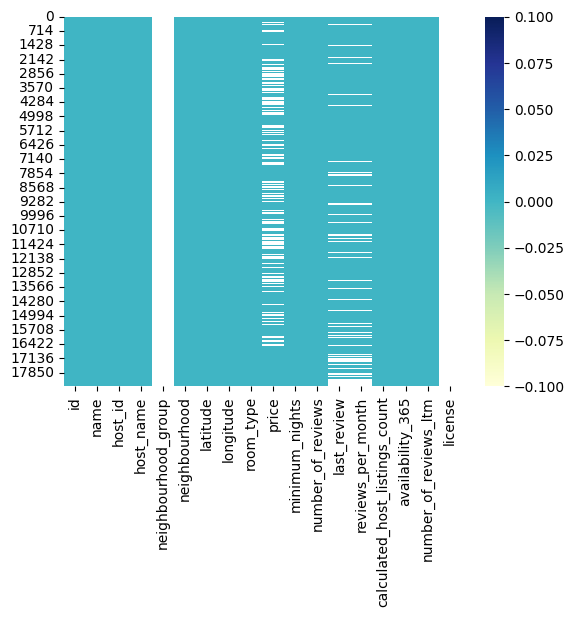

In [2]:
sns.heatmap(df.isna(), cmap="YlGnBu", mask=df.isna())

Dropping neighbourhood group, since all values are NaN.

In [3]:
# Dropping neighbourhood group
df = df.drop(columns='neighbourhood_group')

Dropping license, since all values are NaN.

In [4]:
df = df.drop(columns='license')

Dropping last review, since it won’t be all that useful in the clustering.

In [5]:
df = df.drop(columns='last_review')

Treating NaN values - Price

In [6]:
df['price'].kurt()

1748.4941199990024

In [7]:
# Replacing the NaNs randomly
imp_random = RandomSampleImputer(['price']) 
df = imp_random.fit_transform(df)

Treating NaN values - Reviews per Month

In [8]:
df['reviews_per_month'].kurt()

167.5801491631379

In [9]:
# Replacing the NaNs randomly
imp_random = RandomSampleImputer(['reviews_per_month']) 
df = imp_random.fit_transform(df)

Checking there are no more NaNs.

<Axes: >

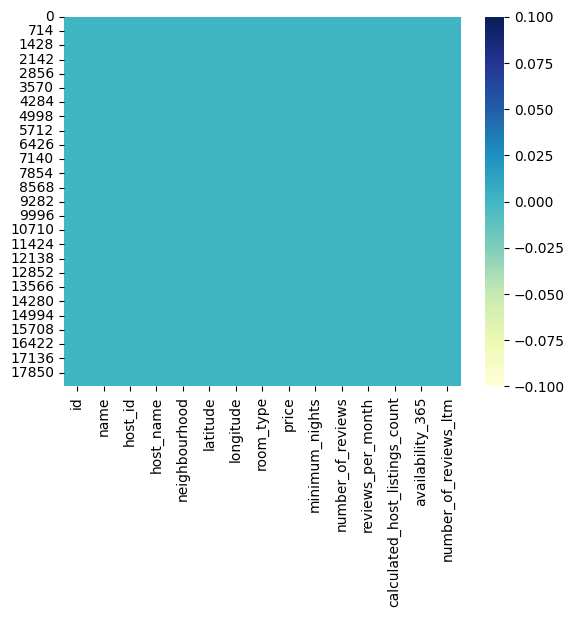

In [10]:
sns.heatmap(df.isna(), cmap="YlGnBu", mask=df.isna())

## Separating the name column

In [55]:
sep= ' · '
name = df['name'].str.split(sep, expand=True)
name = name.rename(columns={0:'rental', 1:'rating', 2:'bedrooms', 3:'beds',4:'bathrooms'})
temp = name['rental'].str.split(' in ', expand=True).rename(columns={0:'property', 1:'location'})
name = temp.join(name).drop(columns='rental')

name.head()

,property,location,rating,bedrooms,beds,bathrooms
0,Home,Copenhagen,★4.91,4 bedrooms,4 beds,1.5 baths
1,Townhouse,Copenhagen,★4.55,6 bedrooms,5 beds,2 baths
2,Rental unit,Copenhagen,★4.85,1 bedroom,1 bed,1 bath
3,Rental unit,Copenhagen,★4.86,1 bedroom,1 bed,1 shared bath
4,Condo,Copenhagen,★4.88,4 bedrooms,2 beds,1.5 baths


## Scaling and encoding the data

In [11]:
encoder = MinMaxScaler()

In [12]:
encoder = OrdinalEncoder()
a = np.array(df['neighbourhood']).reshape(-1,1)
df['neighbourhood_encoded'] = encoder.fit_transform(a) 
df.head(2)

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,neighbourhood_encoded
0,26057,Home in Copenhagen · ★4.91 · 4 bedrooms · 4 be...,109777,Kari,Indre By,55.69307,12.57649,Entire home/apt,2900.0,5,57,0.46,1,356,0,1
1,26473,Townhouse in Copenhagen · ★4.55 · 6 bedrooms ·...,112210,Julia,Indre By,55.67602,12.57540,Entire home/apt,3350.0,3,341,2.12,1,74,37,1


In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df['neighbourhood_encoded']).reshape(-1,1))
Y = scaler.fit_transform(np.array(df['price']).reshape(-1,1))

## Visualizing the features and target variable